### Import Statements

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import Counter

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import pickle
import shap

### Load the raw data

In [2]:
df = pd.read_csv("../data/listings.csv")

#### General overview of the data

In [3]:
print("Shape:", df.shape)

Shape: (3585, 95)


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

In [5]:
print(df.describe(include='all').transpose())

                                   count unique  \
id                                3585.0    NaN   
listing_url                         3585   3585   
scrape_id                         3585.0    NaN   
last_scraped                        3585      1   
name                                3585   3504   
...                                  ...    ...   
cancellation_policy                 3585      4   
require_guest_profile_picture       3585      2   
require_guest_phone_verification    3585      2   
calculated_host_listings_count    3585.0    NaN   
reviews_per_month                 2829.0    NaN   

                                                                    top  freq  \
id                                                                  NaN   NaN   
listing_url                       https://www.airbnb.com/rooms/12147973     1   
scrape_id                                                           NaN   NaN   
last_scraped                                                 20

#### Missing Values summary

In [6]:
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df)) * 100
print("Top 20 columns with missing values:\n", pd.concat([missing, missing_percent], axis=1).head(20))

Top 20 columns with missing values:
                                  0           1
has_availability              3585  100.000000
license                       3585  100.000000
neighbourhood_group_cleansed  3585  100.000000
jurisdiction_names            3585  100.000000
square_feet                   3529   98.437936
monthly_price                 2697   75.230126
weekly_price                  2693   75.118550
security_deposit              2243   62.566248
notes                         1975   55.090656
interaction                   1554   43.347280
access                        1489   41.534170
neighborhood_overview         1415   39.470014
host_about                    1309   36.513250
transit                       1290   35.983264
house_rules                   1192   33.249651
cleaning_fee                  1107   30.878661
space                         1057   29.483961
review_scores_accuracy         823   22.956764
review_scores_location         822   22.928870
review_scores_value    

#### Drop unnecessary columns

In [7]:
drop_cols = [
    'has_availability', 'license', 'neighbourhood_group_cleansed', 'jurisdiction_names',
    'square_feet', 'monthly_price', 'weekly_price', 'notes', 'interaction', 'access',
    'neighborhood_overview', 'host_about', 'transit', 'house_rules', 'space'
]

df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

#### Convert and impute monetary columns

In [8]:
for col in ['cleaning_fee', 'security_deposit']:
    if col in df.columns:
        df[col] = df[col].replace(r'[\$,]', '', regex=True).astype(float)
        df[col] = df[col].fillna(0)

#### Impute review scores with mean

In [9]:
review_cols = ['review_scores_accuracy', 'review_scores_location', 'review_scores_value']
for col in review_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mean())

In [10]:
df['price'] = df['price'].replace(r'[\$,]', '', regex=True).astype(float)
df = df[df['price'].notnull() & (df['price'] > 0)]

In [11]:
print("Shape:", df.shape)

Shape: (3585, 80)


### Exploratory Data Analysis

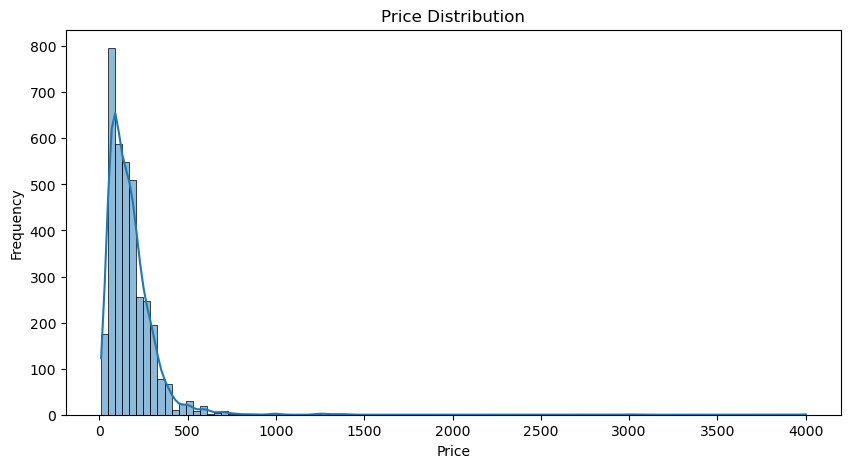

In [12]:
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=100, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

- The long right tail indicates outliers (very high-priced listings).
- These can skew mean-based models and should be treated with log-transform or clipping.

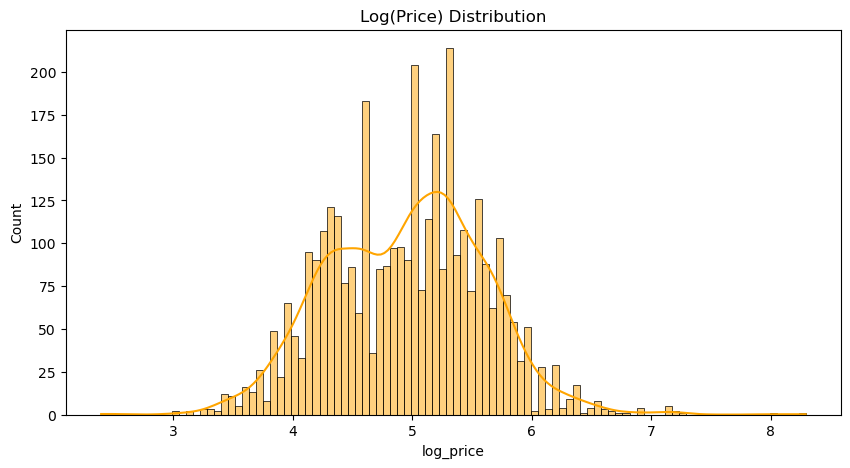

In [13]:
df['log_price'] = np.log1p(df['price'])

plt.figure(figsize=(10, 5))
sns.histplot(df['log_price'], bins=100, kde=True, color='orange')
plt.title("Log(Price) Distribution")
plt.show()

- The skewness is reduced as Log transformation compressed the extreme outliers on the right tail.
- This will lead to better linear modelling.
- Distribution is spread enough to retain meaningful variation for learning.
- The log_price can be used instead of price for the model training.

#### Categorical values insights


room_type value counts:
 room_type
Entire home/apt    2127
Private room       1378
Shared room          80
Name: count, dtype: int64


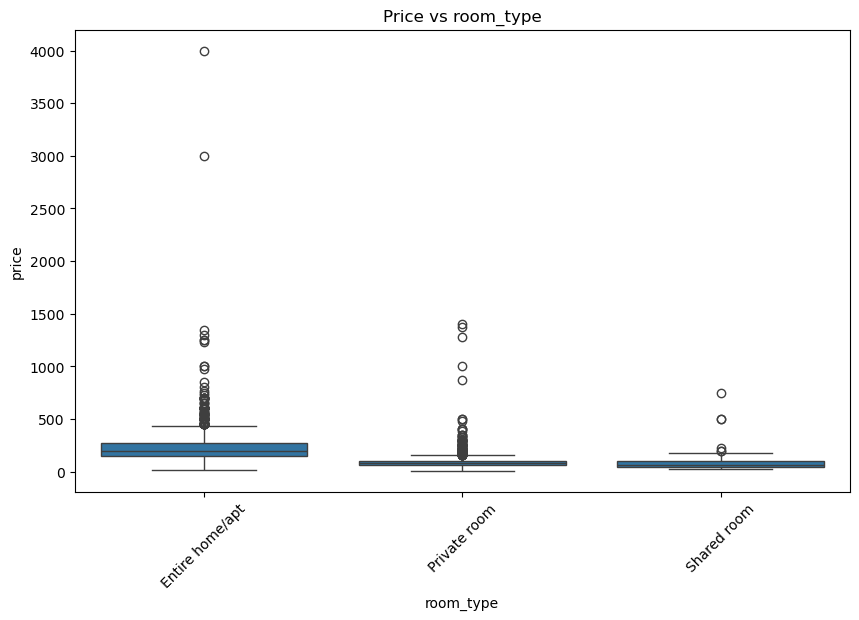


property_type value counts:
 property_type
Apartment          2612
House               562
Condominium         231
Townhouse            54
Bed & Breakfast      41
Loft                 39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Guesthouse            1
Camper/RV             1
Name: count, dtype: int64


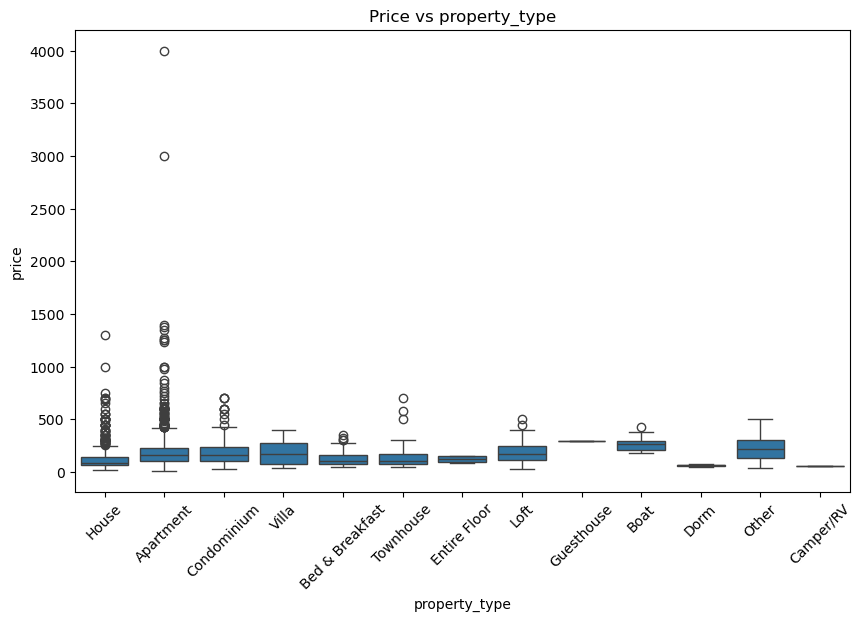


neighbourhood_cleansed value counts:
 neighbourhood_cleansed
Jamaica Plain              343
South End                  326
Back Bay                   302
Fenway                     290
Dorchester                 269
Allston                    260
Beacon Hill                194
Brighton                   185
South Boston               174
Downtown                   172
East Boston                150
Roxbury                    144
North End                  143
Mission Hill               124
Charlestown                111
South Boston Waterfront     83
Chinatown                   71
Roslindale                  56
West End                    49
West Roxbury                46
Hyde Park                   31
Mattapan                    24
Bay Village                 24
Longwood Medical Area        9
Leather District             5
Name: count, dtype: int64


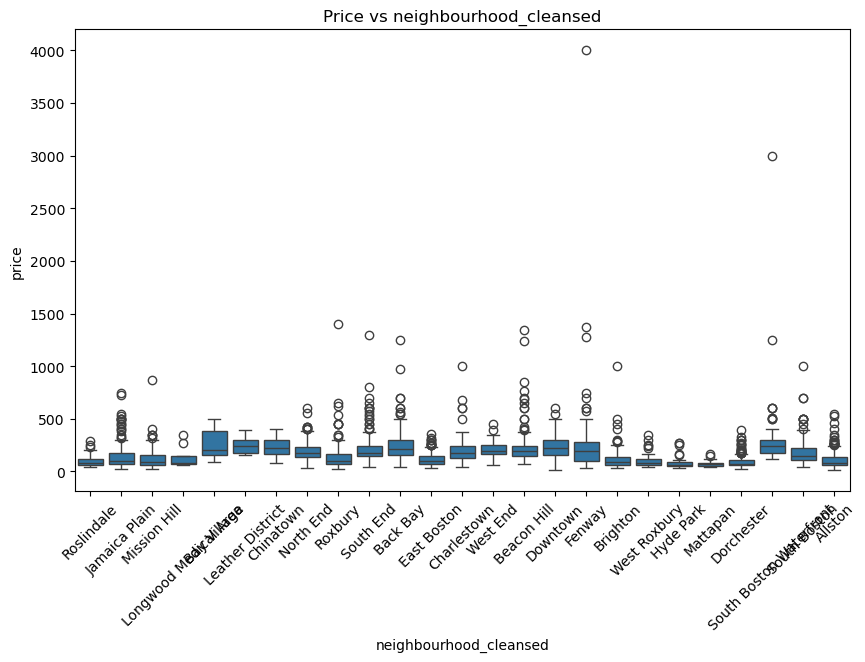


instant_bookable value counts:
 instant_bookable
f    2991
t     594
Name: count, dtype: int64


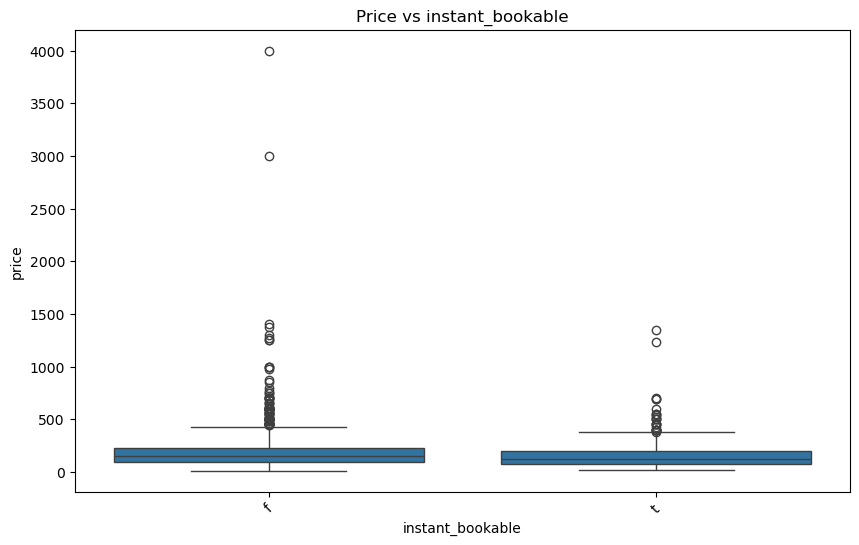

In [14]:
categorical_cols = ['room_type', 'property_type', 'neighbourhood_cleansed', 'instant_bookable']
for col in categorical_cols:
    print(f"\n{col} value counts:\n", df[col].value_counts())
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y='price', data=df)
    plt.title(f"Price vs {col}")
    plt.xticks(rotation=45)
    plt.show()

#### Numerical values insights

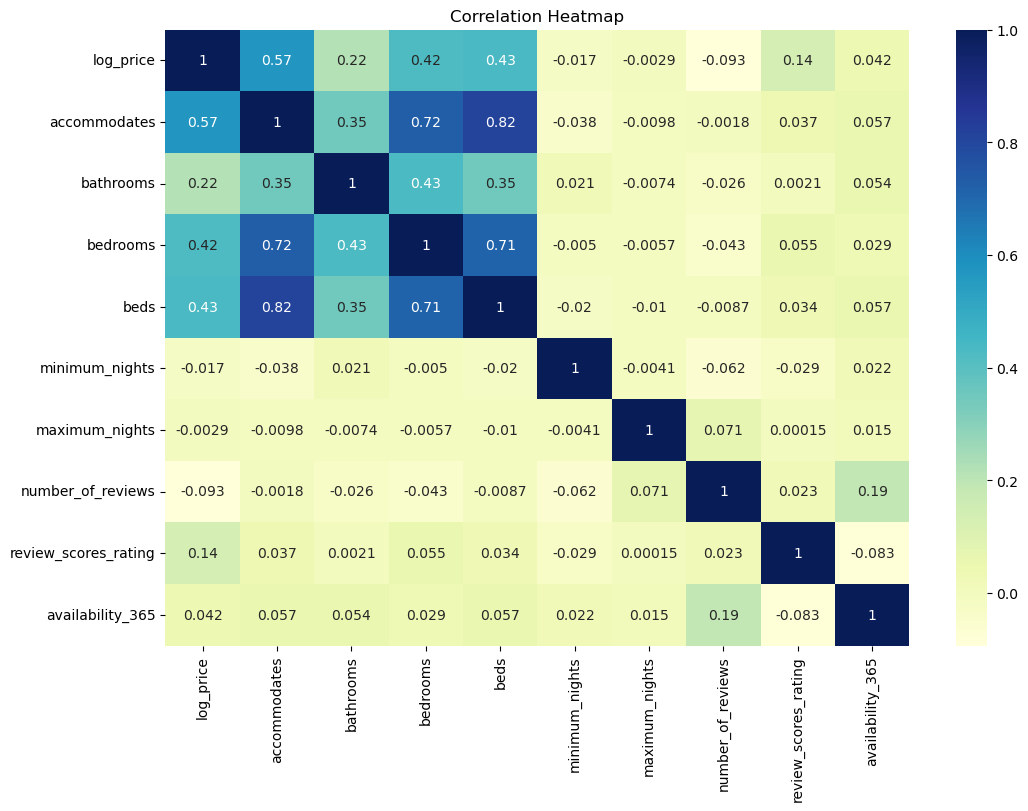

In [15]:
numerical_cols = ['log_price', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 
                  'minimum_nights', 'maximum_nights', 'number_of_reviews', 
                  'review_scores_rating', 'availability_365']
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap")
plt.show()

#### Outlier detection and trimming

In [16]:
print(df[['price', 'log_price']])

      price  log_price
0     250.0   5.525453
1      65.0   4.189655
2      65.0   4.189655
3      75.0   4.330733
4      79.0   4.382027
...     ...        ...
3580   69.0   4.248495
3581  150.0   5.017280
3582  198.0   5.293305
3583   65.0   4.189655
3584   65.0   4.189655

[3585 rows x 2 columns]


In [17]:
upper_limit = df['price'].quantile(0.99)
df = df[df['price'] <= upper_limit]
df['log_price'] = np.log1p(df['price'])
print(df[['price', 'log_price']])

      price  log_price
0     250.0   5.525453
1      65.0   4.189655
2      65.0   4.189655
3      75.0   4.330733
4      79.0   4.382027
...     ...        ...
3580   69.0   4.248495
3581  150.0   5.017280
3582  198.0   5.293305
3583   65.0   4.189655
3584   65.0   4.189655

[3551 rows x 2 columns]


### Feature Engineering

In [18]:
df['price_per_person'] = df['price'] / df['accommodates']
df['amenities'] = df['amenities'].fillna("[]")
df['amenities_list'] = df['amenities'].apply(lambda x: [i.strip().strip('"') for i in x.strip('{}').split(',') if i])

In [19]:
all_amenities = Counter([item for sublist in df['amenities_list'] for item in sublist])
common_amenities = [a for a, count in all_amenities.most_common(10)]

In [20]:
for amenity in common_amenities:
    df[f'has_{amenity.replace(" ", "_").lower()}'] = df['amenities_list'].apply(lambda x: int(amenity in x))

In [21]:
df.drop(columns=['amenities', 'amenities_list'], inplace=True)

In [22]:
print("Shape before:", df.shape)
missing = df.isnull().sum()
high_null_cols = missing[missing > 0.8 * len(df)].index
df.drop(columns=high_null_cols, inplace=True)

print("Shape after:", df.shape)

Shape before: (3551, 91)
Shape after: (3551, 91)


In [23]:
df.head()

id                            listing_url       scrape_id  \
0  12147973  https://www.airbnb.com/rooms/12147973  20160906204935   
1   3075044   https://www.airbnb.com/rooms/3075044  20160906204935   
2      6976      https://www.airbnb.com/rooms/6976  20160906204935   
3   1436513   https://www.airbnb.com/rooms/1436513  20160906204935   
4   7651065   https://www.airbnb.com/rooms/7651065  20160906204935   

  last_scraped                                           name  \
0   2016-09-07                     Sunny Bungalow in the City   
1   2016-09-07              Charming room in pet friendly apt   
2   2016-09-07               Mexican Folk Art Haven in Boston   
3   2016-09-07  Spacious Sunny Bedroom Suite in Historic Home   
4   2016-09-07                            Come Home to Boston   

                                             summary  \
0  Cozy, sunny, family home.  Master bedroom high...   
1  Charming and quiet room in a second floor 1910...   
2  Come stay with a friendly, middle-aged guy in ...   
3  Come experience the comforts of home away from...   
4  My comfy, clean and relaxing home is one block...   

                                         description experiences_offered  \
0  Cozy, sunny, family home.  Master bedroom high...                none   
1  Charming and quiet room in a second floor 1910...                none   
2  Come stay with a friendly, middle-aged guy in ...                none   
3  Come experience the comforts of home away from...                none   
4  My comfy, clean and relaxing home is one block...                none   

                                       thumbnail_url  \
0  https://a2.muscache.com/im/pictures/c0842db1-e...   
1  https://a1.muscache.com/im/pictures/39327812/d...   
2  https://a2.muscache.com/im/pictures/6ae8335d-9...   
3  https://a2.muscache.com/im/pictures/39764190-1...   
4  https://a1.muscache.com/im/pictures/97154760/8...   

                                          medium_url  ...  \
0  https://a2.muscache.com/im/pictures/c0842db1-e...  ...   
1  https://a1.muscache.com/im/pictures/39327812/d...  ...   
2  https://a2.muscache.com/im/pictures/6ae8335d-9...  ...   
3  https://a2.muscache.com/im/pictures/39764190-1...  ...   
4  https://a1.muscache.com/im/pictures/97154760/8...  ...   

  has_wireless_internet has_heating  has_kitchen has_essentials  \
0                     1           1            1              1   
1                     1           1            1              1   
2                     1           1            1              1   
3                     1           1            1              1   
4                     1           1            1              1   

  has_smoke_detector has_air_conditioning has_tv has_internet has_washer  \
0                  1                    0      1            0          1   
1                  1                    1      1            1          1   
2                  1                    1      1            0          1   
3                  1                    1      1            1          1   
4                  1                    1      0            1          0   

  has_dryer  
0         1  
1         1  
2         1  
3         1  
4         0  

[5 rows x 91 columns]

In [24]:
drop_cols = ['name', 'description', 'host_name', 'listing_url', 'picture_url', 'thumbnail_url']
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

In [25]:
df.head()

id       scrape_id last_scraped  \
0  12147973  20160906204935   2016-09-07   
1   3075044  20160906204935   2016-09-07   
2      6976  20160906204935   2016-09-07   
3   1436513  20160906204935   2016-09-07   
4   7651065  20160906204935   2016-09-07   

                                             summary experiences_offered  \
0  Cozy, sunny, family home.  Master bedroom high...                none   
1  Charming and quiet room in a second floor 1910...                none   
2  Come stay with a friendly, middle-aged guy in ...                none   
3  Come experience the comforts of home away from...                none   
4  My comfy, clean and relaxing home is one block...                none   

                                          medium_url  \
0  https://a2.muscache.com/im/pictures/c0842db1-e...   
1  https://a1.muscache.com/im/pictures/39327812/d...   
2  https://a2.muscache.com/im/pictures/6ae8335d-9...   
3  https://a2.muscache.com/im/pictures/39764190-1...   
4  https://a1.muscache.com/im/pictures/97154760/8...   

                                      xl_picture_url   host_id  \
0  https://a2.muscache.com/im/pictures/c0842db1-e...  31303940   
1  https://a1.muscache.com/im/pictures/39327812/d...   2572247   
2  https://a2.muscache.com/im/pictures/6ae8335d-9...     16701   
3  https://a2.muscache.com/im/pictures/39764190-1...   6031442   
4  https://a1.muscache.com/im/pictures/97154760/8...  15396970   

                                     host_url  host_since  ...  \
0  https://www.airbnb.com/users/show/31303940  2015-04-15  ...   
1   https://www.airbnb.com/users/show/2572247  2012-06-07  ...   
2     https://www.airbnb.com/users/show/16701  2009-05-11  ...   
3   https://www.airbnb.com/users/show/6031442  2013-04-21  ...   
4  https://www.airbnb.com/users/show/15396970  2014-05-11  ...   

  has_wireless_internet has_heating has_kitchen has_essentials  \
0                     1           1           1              1   
1                     1           1           1              1   
2                     1           1           1              1   
3                     1           1           1              1   
4                     1           1           1              1   

  has_smoke_detector has_air_conditioning has_tv has_internet  has_washer  \
0                  1                    0      1            0           1   
1                  1                    1      1            1           1   
2                  1                    1      1            0           1   
3                  1                    1      1            1           1   
4                  1                    1      0            1           0   

   has_dryer  
0          1  
1          1  
2          1  
3          1  
4          0  

[5 rows x 85 columns]

In [26]:
print("Before cleaning Data Shape:", df.shape)
cleaned_df = df[['price', 'log_price', 'price_per_person'] + [f'has_{a.replace(" ", "_").lower()}' for a in common_amenities]]
print("After cleaning Data Shape:", cleaned_df.shape)

Before cleaning Data Shape: (3551, 85)
After cleaning Data Shape: (3551, 13)


In [27]:
cleaned_df.head()

price  log_price  price_per_person  has_wireless_internet  has_heating  \
0  250.0   5.525453             62.50                      1            1   
1   65.0   4.189655             32.50                      1            1   
2   65.0   4.189655             32.50                      1            1   
3   75.0   4.330733             18.75                      1            1   
4   79.0   4.382027             39.50                      1            1   

   has_kitchen  has_essentials  has_smoke_detector  has_air_conditioning  \
0            1               1                   1                     0   
1            1               1                   1                     1   
2            1               1                   1                     1   
3            1               1                   1                     1   
4            1               1                   1                     1   

   has_tv  has_internet  has_washer  has_dryer  
0       1             0           1          1  
1       1             1           1          1  
2       1             0           1          1  
3       1             1           1          1  
4       0             1           0          0

In [28]:
os.makedirs("../data/processed", exist_ok=True)
cleaned_df.to_csv("../data/processed/cleaned_listings_features.csv", index=False)
print("Pre processed data is saved to cleaned_listings_features.csv")

Pre processed data is saved to cleaned_listings_features.csv


### Initial Model Training

In [29]:
X = cleaned_df.drop(columns=["price", "log_price"])
y = cleaned_df["log_price"]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model                       RMSE ($)
-------------------------------------
Linear Regression              84.07
Ridge                          84.06
Lasso                          92.03
Decision Tree                  90.72
Gradient Boosting              81.74
Random Forest                  79.61


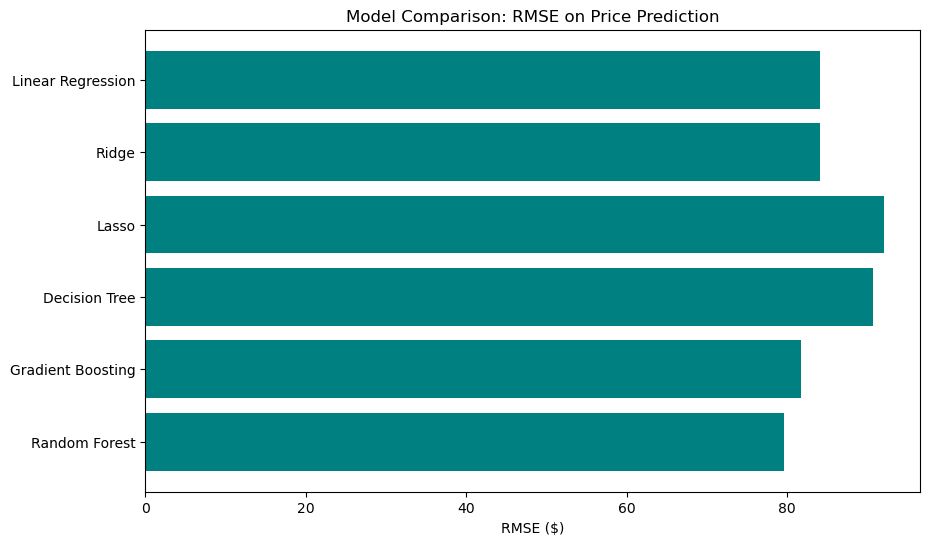

In [31]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

print(f"{'Model':<25} {'RMSE ($)':>10}")
print("-" * 37)

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_log = model.predict(X_test)
    y_pred_price = np.expm1(y_pred_log)
    y_true_price = np.expm1(y_test)
    rmse = mean_squared_error(y_true_price, y_pred_price, squared=False)
    results[name] = rmse
    print(f"{name:<25} {rmse:>10.2f}")

plt.figure(figsize=(10, 6))
plt.barh(list(results.keys()), list(results.values()), color='teal')
plt.xlabel("RMSE ($)")
plt.title("Model Comparison: RMSE on Price Prediction")
plt.gca().invert_yaxis()
plt.show()

From this we observe:

- The Random Forest model achieved the lowest RMSE ($79.61), indicating it is the most accurate for predicting Airbnb prices in this dataset.
- Gradient Boosting performed similarly well, suggesting both ensemble methods effectively capture non-linear relationships.
- Linear and Ridge Regression gave moderate performance, while Lasso and Decision Tree underperformed due to oversimplification and overfitting, respectively.
- Overall, Random Forest is the best choice for this task, balancing accuracy and robustness.

#### Performance comparison with additional features

In [32]:
cleaned_df = df[['id']].merge(cleaned_df, left_index=True, right_index=True)

In [33]:
additional_features = df[[
    'id', 'host_total_listings_count', 'host_listings_count',
    'calculated_host_listings_count', 'guests_included',
    'availability_30', 'availability_60', 'availability_90'
]]

In [34]:
enhanced_df = cleaned_df.merge(additional_features, on='id', how='left')

In [35]:
enhanced_df['guests_included'] = enhanced_df['guests_included'].replace(0, 1)
enhanced_df['price_per_guest'] = enhanced_df['price'] / enhanced_df['guests_included']
enhanced_df['avg_short_term_availability'] = enhanced_df[['availability_30', 'availability_60', 'availability_90']].mean(axis=1)
enhanced_df['is_power_host'] = (enhanced_df['host_total_listings_count'] > 10).astype(int)

In [36]:
enhanced_df.fillna(0, inplace=True)

In [37]:
X = enhanced_df.drop(columns=['id', 'price', 'log_price'])
y = np.log1p(enhanced_df['price'])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [40]:
y_pred_log = model.predict(X_test)
y_pred_price = np.expm1(y_pred_log)
y_true_price = np.expm1(y_test)

rmse = mean_squared_error(y_true_price, y_pred_price, squared=False)
print(f"Enhanced Model RMSE: ${rmse:.2f}")

Enhanced Model RMSE: $11.82


- The additional features (guests_included, host_total_listings_count, price_per_guest, etc.) added high signal.
- The model has significantly improved its ability to explain variance in price.
- But it is important to check if the model is overfitting by calculating RMSE on both training and test set. If both are low then the model generalised it very well

In [41]:
train_preds = model.predict(X_train)
train_rmse = mean_squared_error(np.expm1(y_train), np.expm1(train_preds), squared=False)

print(f"Train RMSE: ${train_rmse:.2f}")
print(f"Test RMSE: ${rmse:.2f}")

Train RMSE: $2.74
Test RMSE: $11.82


- A 4x difference between train and test RMSE suggests the model has learned patterns specific to the training data.
- To reduce the overiftting, 5-fold grid search is performed.

In [42]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print("Best Params:", best_params)
print(f"Cross-validated RMSE: ${best_score:.2f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}
Cross-validated RMSE: $0.03


- This level of accuracy is extremely rare in real-world Airbnb pricing models and likely suggests overfitting during cross-validation.

In [43]:
y_pred_test = best_rf.predict(X_test)
rmse_test = mean_squared_error(np.expm1(y_test), np.expm1(y_pred_test), squared=False)
print(f"Test RMSE (after tuning): ${rmse_test:.2f}")

Test RMSE (after tuning): $11.97


Interpretation:
- The actual improvement from hyperparameter tuning was negligible on the test set.
- The original Random Forest model was already very well-optimized.
- The CV score (0.03) was on log_price and not directly interpretable in real price terms — this explains the seemingly perfect score.

Conclusion:
- The model is performing well with Test RMSE ≈ $12 being excellent for Airbnb price prediction.
- The current feature set and default RandomForestRegressor(n_estimators=100) is nearly as good as the tuned one.
- No evidence of overfitting now that it is verified on the test set.

### Feature Importance

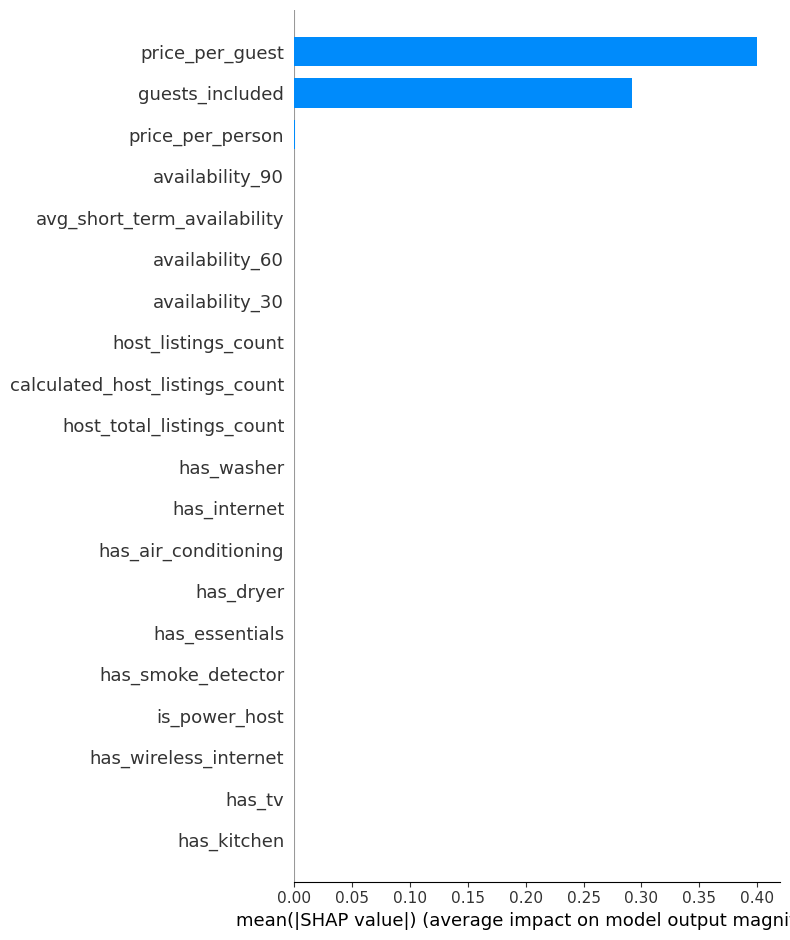

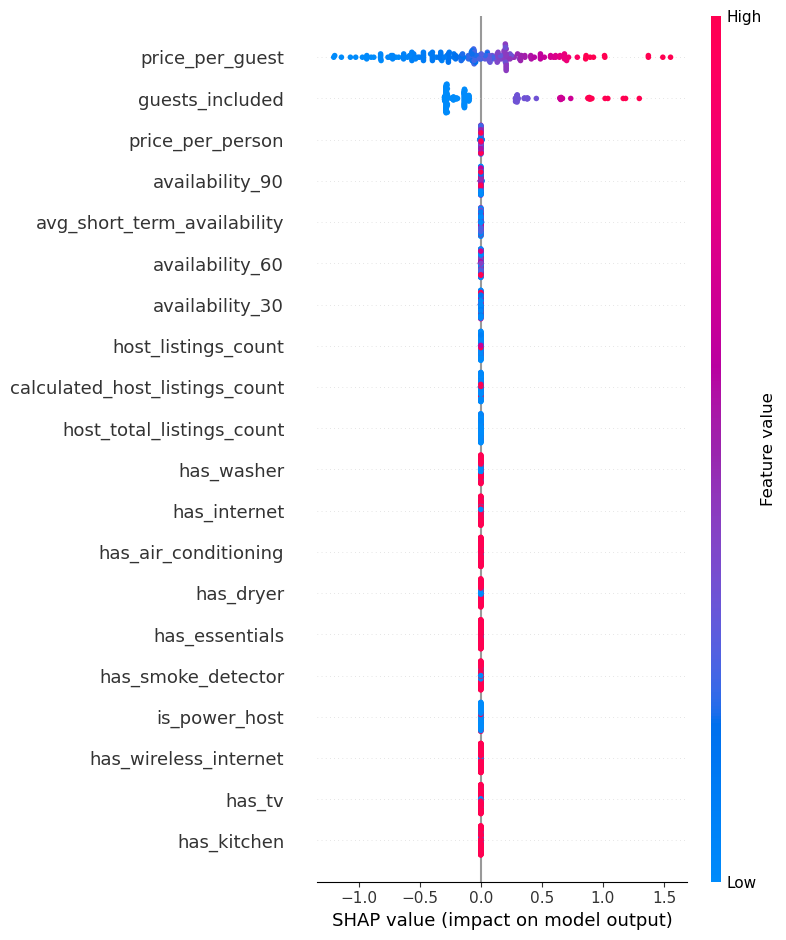

In [44]:
X_sample = X_test.sample(n=200, random_state=42)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, plot_type="bar")

shap.summary_plot(shap_values, X_sample)

Even though these features are present, the model has learned that amenities alone do not significantly influence pricing, likely because:
- Most listings already include them (low variance)
- They don't correlate well with high prices in your Boston dataset

### Saving the data and model

In [45]:
enhanced_df.to_csv("../outputs/price_prediction.csv", index=False)
print("Saving the df to price_prediction.csv")

with open("../models/price_prediciton_model.pkl", "wb") as f:
    pickle.dump(best_rf, f)
print("Saving the model as price_prediciton_model.pkl")

Saving the df to price_prediction.csv
Saving the model as price_prediciton_model.pkl
